# Predicting H1N1 vaccination refusal using best features 
## Features selected from Logistic Regression Classifier

This notebook uses 15 best features as selected using Logistic Regression, listed below:

* `doctor_recc_h1n1`
* `employment_industry`
* `health_insurance`
* `health_worker`
* `employment_occupation`
* `doctor_recc_seasonal`
* `opinion_h1n1_vacc_effective`
* `education`
* `opinion_h1n1_risk`
* `chronic_med_condition'`
* `hhs_geo_region`
* `rent_or_own`
* `age_group`
* `behavioral_antiviral_meds`
* `h1n1_vaccine`
* `seasonal_vaccine`

The notebook runs three kinds of models. 

1. Using best features and engineered features, and balancing classes using SMOTE
2. Using features as is, and SMOTE for balancing features
3. Using features and imbalanced classes as is

The findings are summarized below:

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
feat.engg + SMOTE|0.817|0.899|0.865|0.753|
feat as is + SMOTE|0.824|0.901|0.873|0.759|
feat as is|0.851|0.876|0.944|0.725|

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                            roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Using features from LogReg List with feature engineering and SMOTE

In [2]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [3]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [4]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [5]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [6]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [7]:
features_to_use = pd.read_csv('../data/logreg_H1N1_feature_imp.csv')

In [8]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['doctor_recc_h1n1',
 'employment_industry',
 'health_insurance',
 'health_worker',
 'employment_occupation',
 'doctor_recc_seasonal',
 'opinion_h1n1_vacc_effective',
 'education',
 'opinion_h1n1_risk',
 'chronic_med_condition',
 'hhs_geo_region',
 'rent_or_own',
 'age_group',
 'behavioral_antiviral_meds',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [9]:
data = data[features]

In [10]:
data.columns

Index(['doctor_recc_h1n1', 'employment_industry', 'health_insurance',
       'health_worker', 'employment_occupation', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'education', 'opinion_h1n1_risk',
       'chronic_med_condition', 'hhs_geo_region', 'rent_or_own', 'age_group',
       'behavioral_antiviral_meds', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

Doctor recommended features

In [11]:
# #####
data['doctor_recc_h1n1'].value_counts()

0.0            19139
1.0             5408
no_response     2160
Name: doctor_recc_h1n1, dtype: int64

In [12]:
data['doctor_recc_h1n1'].dtypes

dtype('O')

In [13]:
data['doctor_recc_h1n1'] = data['doctor_recc_h1n1'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})

data['doctor_recc_h1n1'].value_counts()

1    19139
2     5408
0     2160
Name: doctor_recc_h1n1, dtype: int64

In [14]:
#####
data['doctor_recc_seasonal'].value_counts()

0.0            16453
1.0             8094
no_response     2160
Name: doctor_recc_seasonal, dtype: int64

In [15]:
data['doctor_recc_seasonal'] = data['doctor_recc_seasonal'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})
data['doctor_recc_seasonal'].value_counts()

1    16453
2     8094
0     2160
Name: doctor_recc_seasonal, dtype: int64

In [16]:
#####
data['chronic_med_condition'].value_counts()

0.0            18446
1.0             7290
no_response      971
Name: chronic_med_condition, dtype: int64

In [17]:
data['chronic_med_condition'] = data['chronic_med_condition'].replace({'no_response' : 0, '0.0' : 1, '1.0': 2})
data['chronic_med_condition'].value_counts()

1    18446
2     7290
0      971
Name: chronic_med_condition, dtype: int64

In [18]:
#####
data['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [19]:
data['age_group'].replace({
    '18 - 34 Years' : 0,
    '35 - 44 Years' : 1,
    '45 - 54 Years' : 2,
    '55 - 64 Years' : 3,
    '55 - 64 Years' : 4,
    '65+ Years' : 5
    
}, inplace=True)

data['age_group'].value_counts()

5    6843
4    5563
2    5238
0    5215
1    3848
Name: age_group, dtype: int64

In [20]:
#####

data['health_worker'].value_counts()

no             23004
yes             2899
no_response      804
Name: health_worker, dtype: int64

In [21]:
data['health_worker'].replace({'no_response': 0,'no': 1, 'yes': 2}, inplace=True)
data['health_worker'].value_counts()

1    23004
2     2899
0      804
Name: health_worker, dtype: int64

In [22]:
# make a new feature h1n1_all for participants who had both h1n1_concern and h1n1_knowledge
# data[['h1n1_concern', 'h1n1_knowledge']].dtypes

In [23]:
# data['h1n1_all'] = data['h1n1_concern'] * data['h1n1_knowledge']

In [24]:
# make a new feature h1n1_all for participants who responded yes to all the behavior questions
behaviour_columns = [column for column in list(data.columns) if 'behavioral' in column]
data[behaviour_columns].dtypes

behavioral_antiviral_meds    float64
dtype: object

In [25]:
# data['behavioral_all'] = 1

# for column in behaviour_columns:
#     data['behavioral_all'] = data['behavioral_all'] * data[column]

In [26]:
# make a new feature opinion_all for participants based on their opinion scores to the opinion questions
opinion_columns = [column for column in list(data.columns) if 'opinion' in column]
data[opinion_columns].dtypes

opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
dtype: object

In [27]:
data['opinion_all'] = 1

for column in opinion_columns:
    data['opinion_all'] = data['opinion_all'] * data[column]

In [28]:
# doctor recommended columns
doctor_columns = [column for column in list(data.columns) if 'doctor' in column]

In [29]:
doctor_columns

['doctor_recc_h1n1', 'doctor_recc_seasonal']

In [30]:
data['doctor_recc_all'] = 1

for column in opinion_columns:
    data['doctor_recc_all'] = data['doctor_recc_all'] * data[column]

In [31]:
# health_worker and age group

data['health_worker_by_age'] = data['health_worker'] * data['age_group']

In [32]:
data.columns

Index(['doctor_recc_h1n1', 'employment_industry', 'health_insurance',
       'health_worker', 'employment_occupation', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'education', 'opinion_h1n1_risk',
       'chronic_med_condition', 'hhs_geo_region', 'rent_or_own', 'age_group',
       'behavioral_antiviral_meds', 'h1n1_vaccine', 'seasonal_vaccine',
       'opinion_all', 'doctor_recc_all', 'health_worker_by_age'],
      dtype='object')

**dummify x**

In [33]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['employment_industry',
 'health_insurance',
 'employment_occupation',
 'education',
 'hhs_geo_region',
 'rent_or_own']

In [34]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [35]:
X.columns

Index(['doctor_recc_h1n1', 'health_worker', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'chronic_med_condition', 'age_group', 'behavioral_antiviral_meds',
       'opinion_all', 'doctor_recc_all', 'health_worker_by_age',
       'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy',
       'employment_industry_dotnnunm', 'employment_industry_fcxhlnwr',
       'employment_industry_haxffmxo', 'employment_industry_ldnlellj',
       'employment_industry_mcubkhph', 'employment_industry_mfikgejo',
       'employment_industry_msuufmds', 'employment_industry_nduyfdeo',
       'employment_industry_no_response', 'employment_industry_phxvnwax',
       'employment_industry_pxcmvdjn', 'employment_industry_qnlwzans',
       'employment_industry_rucpziij', 'employment_industry_saaquncn',
       'employment_industry_vjjrobsf', 'employment_industry_wlfvacwt',
       'employment_industry_wxleyezf', 'employment_industry_xicduogh',
       'employment_in

In [36]:
y = data['h1n1_vaccine']

In [37]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [38]:
# balance classes

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [39]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [40]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [41]:
X.columns

Index(['doctor_recc_h1n1', 'health_worker', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'chronic_med_condition', 'age_group', 'behavioral_antiviral_meds',
       'opinion_all', 'doctor_recc_all', 'health_worker_by_age',
       'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy',
       'employment_industry_dotnnunm', 'employment_industry_fcxhlnwr',
       'employment_industry_haxffmxo', 'employment_industry_ldnlellj',
       'employment_industry_mcubkhph', 'employment_industry_mfikgejo',
       'employment_industry_msuufmds', 'employment_industry_nduyfdeo',
       'employment_industry_no_response', 'employment_industry_phxvnwax',
       'employment_industry_pxcmvdjn', 'employment_industry_qnlwzans',
       'employment_industry_rucpziij', 'employment_industry_saaquncn',
       'employment_industry_vjjrobsf', 'employment_industry_wlfvacwt',
       'employment_industry_wxleyezf', 'employment_industry_xicduogh',
       'employment_in

**Run model**

In [42]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [43]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


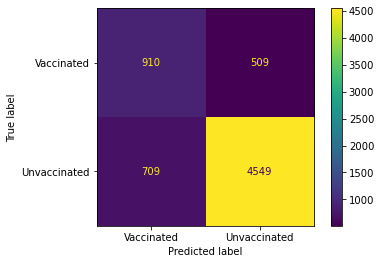

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [45]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.817582746742549, 0.8298052920619071)

In [46]:
precision_score(y_test, test_pred)

0.8993673388691182

In [47]:
recall_score(y_test, test_pred)

0.8651578546976036

In [48]:
roc_auc_score(y_test, test_pred)

0.7532272712529597

In [49]:
balanced_accuracy_score(y_test, test_pred)

0.7532272712529597

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
feat.engg + SMOTE|0.817|0.899|0.865|0.753|


### Using top features from logreg, without feature engineering, but with SMOTE

In [50]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [51]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [52]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [53]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [54]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [55]:
features_to_use = pd.read_csv('../data/logreg_H1N1_feature_imp.csv')

In [56]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['doctor_recc_h1n1',
 'employment_industry',
 'health_insurance',
 'health_worker',
 'employment_occupation',
 'doctor_recc_seasonal',
 'opinion_h1n1_vacc_effective',
 'education',
 'opinion_h1n1_risk',
 'chronic_med_condition',
 'hhs_geo_region',
 'rent_or_own',
 'age_group',
 'behavioral_antiviral_meds',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [57]:
data = data[features]

In [58]:
data.columns

Index(['doctor_recc_h1n1', 'employment_industry', 'health_insurance',
       'health_worker', 'employment_occupation', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'education', 'opinion_h1n1_risk',
       'chronic_med_condition', 'hhs_geo_region', 'rent_or_own', 'age_group',
       'behavioral_antiviral_meds', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

**dummify x**

In [59]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['doctor_recc_h1n1',
 'employment_industry',
 'health_insurance',
 'health_worker',
 'employment_occupation',
 'doctor_recc_seasonal',
 'education',
 'chronic_med_condition',
 'hhs_geo_region',
 'rent_or_own',
 'age_group']

In [60]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [61]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'behavioral_antiviral_meds', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response', 'employment_industry_atmlpfrs',
       'employment_industry_cfqqtusy', 'employment_industry_dotnnunm',
       'employment_industry_fcxhlnwr', 'employment_industry_haxffmxo',
       'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
       'employment_industry_mfikgejo', 'employment_industry_msuufmds',
       'employment_industry_nduyfdeo', 'employment_industry_no_response',
       'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn',
       'employment_industry_qnlwzans', 'employment_industry_rucpziij',
       'employment_industry_saaquncn', 'employment_industry_vjjrobsf',
       'employment_industry_wlfvacwt', 'employment_industry_wxleyezf',
       'employment_industry_xicduogh', 'employment_industry_xqicxuve',
       'health_insurance_no_response', 'health_insurance_yes',
       'health_worker_no_response'

In [62]:
y = data['h1n1_vaccine']

In [63]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [64]:
# balance classes

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [65]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [66]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [67]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'behavioral_antiviral_meds', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response', 'employment_industry_atmlpfrs',
       'employment_industry_cfqqtusy', 'employment_industry_dotnnunm',
       'employment_industry_fcxhlnwr', 'employment_industry_haxffmxo',
       'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
       'employment_industry_mfikgejo', 'employment_industry_msuufmds',
       'employment_industry_nduyfdeo', 'employment_industry_no_response',
       'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn',
       'employment_industry_qnlwzans', 'employment_industry_rucpziij',
       'employment_industry_saaquncn', 'employment_industry_vjjrobsf',
       'employment_industry_wlfvacwt', 'employment_industry_wxleyezf',
       'employment_industry_xicduogh', 'employment_industry_xqicxuve',
       'health_insurance_no_response', 'health_insurance_yes',
       'health_worker_no_response'

**Run model**

In [68]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [69]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


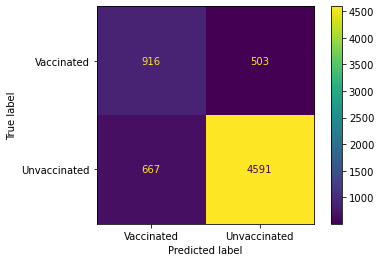

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [71]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8247716040137787, 0.8333000499251123)

In [72]:
precision_score(y_test, test_pred)

0.9012563800549667

In [73]:
recall_score(y_test, test_pred)

0.8731456827691138

In [74]:
roc_auc_score(y_test, test_pred)

0.7593353501935773

In [75]:
balanced_accuracy_score(y_test, test_pred)

0.7593353501935773

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
feat.engg + SMOTE|0.817|0.899|0.865|0.753|
feat as is + SMOTE|0.824|0.901|0.873|0.759|


### Using top features from logreg without feature engineering or smote

In [76]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [77]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [78]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [79]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [80]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [81]:
features_to_use = pd.read_csv('../data/logreg_H1N1_feature_imp.csv')

In [82]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['doctor_recc_h1n1',
 'employment_industry',
 'health_insurance',
 'health_worker',
 'employment_occupation',
 'doctor_recc_seasonal',
 'opinion_h1n1_vacc_effective',
 'education',
 'opinion_h1n1_risk',
 'chronic_med_condition',
 'hhs_geo_region',
 'rent_or_own',
 'age_group',
 'behavioral_antiviral_meds',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [83]:
data = data[features]

In [84]:
data.columns

Index(['doctor_recc_h1n1', 'employment_industry', 'health_insurance',
       'health_worker', 'employment_occupation', 'doctor_recc_seasonal',
       'opinion_h1n1_vacc_effective', 'education', 'opinion_h1n1_risk',
       'chronic_med_condition', 'hhs_geo_region', 'rent_or_own', 'age_group',
       'behavioral_antiviral_meds', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

**dummify x**

In [85]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['doctor_recc_h1n1',
 'employment_industry',
 'health_insurance',
 'health_worker',
 'employment_occupation',
 'doctor_recc_seasonal',
 'education',
 'chronic_med_condition',
 'hhs_geo_region',
 'rent_or_own',
 'age_group']

In [86]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [87]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'behavioral_antiviral_meds', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response', 'employment_industry_atmlpfrs',
       'employment_industry_cfqqtusy', 'employment_industry_dotnnunm',
       'employment_industry_fcxhlnwr', 'employment_industry_haxffmxo',
       'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
       'employment_industry_mfikgejo', 'employment_industry_msuufmds',
       'employment_industry_nduyfdeo', 'employment_industry_no_response',
       'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn',
       'employment_industry_qnlwzans', 'employment_industry_rucpziij',
       'employment_industry_saaquncn', 'employment_industry_vjjrobsf',
       'employment_industry_wlfvacwt', 'employment_industry_wxleyezf',
       'employment_industry_xicduogh', 'employment_industry_xqicxuve',
       'health_insurance_no_response', 'health_insurance_yes',
       'health_worker_no_response'

In [88]:
y = data['h1n1_vaccine']

In [89]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [90]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [91]:
y_train = np.array(y_train)
y_test = np.array(y_test)

**Run model**

In [92]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [93]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

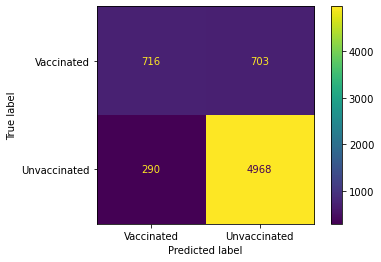

In [94]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [95]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8512805152014378, 0.8618072890664004)

In [96]:
precision_score(y_test, test_pred)

0.876035972491624

In [97]:
recall_score(y_test, test_pred)

0.9448459490300495

In [98]:
roc_auc_score(y_test, test_pred)

0.7247133198286259

In [99]:
balanced_accuracy_score(y_test, test_pred)

0.7247133198286259

### Conclusions

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
feat.engg + SMOTE|0.817|0.899|0.865|0.753|
feat as is + SMOTE|0.824|0.901|0.873|0.759|
feat as is|0.851|0.876|0.944|0.725|